In [1]:
%%capture
!pip install transformers

In [1]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [3]:
from google.colab import files

uploaded = files.upload()

Saving training_nlp.csv to training_nlp.csv


In [4]:
df = pd.read_csv('training_nlp.csv', sep='\t')
df.head()

,file_name,misogynous,shaming,stereotype,objectification,violence,Text Transcription
0,1.jpg,0,0,0,0,0,Milk Milk.zip
1,10.jpg,1,0,0,0,1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S..."
2,1000.jpg,0,0,0,0,0,BREAKING NEWS: Russia releases photo of DONALD...
3,10000.jpg,0,0,0,0,0,MAN SEEKING WOMAN Ignad 18 O
4,10006.jpg,0,0,0,0,0,Me explaining the deep lore of. J.R.R. Tolkein...


In [5]:
df['TextTranscription'] = df['Text Transcription']
df

,file_name,misogynous,shaming,stereotype,objectification,violence,Text Transcription,TextTranscription
0,1.jpg,0,0,0,0,0,Milk Milk.zip,Milk Milk.zip
1,10.jpg,1,0,0,0,1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S...","ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S..."
2,1000.jpg,0,0,0,0,0,BREAKING NEWS: Russia releases photo of DONALD...,BREAKING NEWS: Russia releases photo of DONALD...
3,10000.jpg,0,0,0,0,0,MAN SEEKING WOMAN Ignad 18 O,MAN SEEKING WOMAN Ignad 18 O
4,10006.jpg,0,0,0,0,0,Me explaining the deep lore of. J.R.R. Tolkein...,Me explaining the deep lore of. J.R.R. Tolkein...
...,...,...,...,...,...,...,...,...
9995,15002.jpg,0,0,0,0,0,WAITING FOR THE END OF THE COVID imgflip.com,WAITING FOR THE END OF THE COVID imgflip.com
9996,15003.jpg,0,0,0,0,0,SMART WOMEN ARE AROUND imgflip.com,SMART WOMEN ARE AROUND imgflip.com
9997,15004.jpg,0,0,0,0,0,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com
9998,15005.jpg,0,0,0,0,0,COOKING FOR MY WIFE imgflip.com,COOKING FOR MY WIFE imgflip.com


In [6]:
dataset = pd.DataFrame()
dataset['misogynous'] = df['misogynous']
dataset['TextTranscription'] = df['TextTranscription']
dataset

,misogynous,TextTranscription
0,0,Milk Milk.zip
1,1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S..."
2,0,BREAKING NEWS: Russia releases photo of DONALD...
3,0,MAN SEEKING WOMAN Ignad 18 O
4,0,Me explaining the deep lore of. J.R.R. Tolkein...
...,...,...
9995,0,WAITING FOR THE END OF THE COVID imgflip.com
9996,0,SMART WOMEN ARE AROUND imgflip.com
9997,0,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com
9998,0,COOKING FOR MY WIFE imgflip.com


In [7]:
del df['Text Transcription']
df

,file_name,misogynous,shaming,stereotype,objectification,violence,TextTranscription
0,1.jpg,0,0,0,0,0,Milk Milk.zip
1,10.jpg,1,0,0,0,1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S..."
2,1000.jpg,0,0,0,0,0,BREAKING NEWS: Russia releases photo of DONALD...
3,10000.jpg,0,0,0,0,0,MAN SEEKING WOMAN Ignad 18 O
4,10006.jpg,0,0,0,0,0,Me explaining the deep lore of. J.R.R. Tolkein...
...,...,...,...,...,...,...,...
9995,15002.jpg,0,0,0,0,0,WAITING FOR THE END OF THE COVID imgflip.com
9996,15003.jpg,0,0,0,0,0,SMART WOMEN ARE AROUND imgflip.com
9997,15004.jpg,0,0,0,0,0,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com
9998,15005.jpg,0,0,0,0,0,COOKING FOR MY WIFE imgflip.com


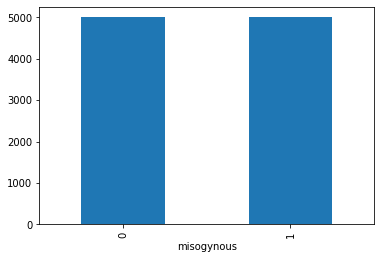

In [8]:
df.groupby(['misogynous']).size().plot.bar()

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'0':0,
          '1':1
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[str(label)] for label in df['misogynous']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['TextTranscription']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [11]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc
                
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [12]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [13]:
df['TextTranscription'] = df['TextTranscription'].str.lower()
df

,file_name,misogynous,shaming,stereotype,objectification,violence,TextTranscription
0,1.jpg,0,0,0,0,0,milk milk.zip
1,10.jpg,1,0,0,0,1,"roses are red, violets are blue if you don't s..."
2,1000.jpg,0,0,0,0,0,breaking news: russia releases photo of donald...
3,10000.jpg,0,0,0,0,0,man seeking woman ignad 18 o
4,10006.jpg,0,0,0,0,0,me explaining the deep lore of. j.r.r. tolkein...
...,...,...,...,...,...,...,...
9995,15002.jpg,0,0,0,0,0,waiting for the end of the covid imgflip.com
9996,15003.jpg,0,0,0,0,0,smart women are around imgflip.com
9997,15004.jpg,0,0,0,0,0,good girls are behind the corner imgflip.com
9998,15005.jpg,0,0,0,0,0,cooking for my wife imgflip.com


In [14]:
np.random.seed(112)
df_train, df_val = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df))])

print(len(df_train),len(df_val))

8000 2000


In [15]:
df_train

,file_name,misogynous,shaming,stereotype,objectification,violence,TextTranscription
6252,5999.jpg,0,0,0,0,0,oh you're not gay? name every women
4684,4334.jpg,0,0,0,0,0,when she buys a new toy: heinerle knatterwalze...
1731,1294.jpg,0,0,0,0,0,cyberbullying? here's one quick solution memes...
4742,4391.jpg,1,0,0,1,0,"girlfriend catches you jerking off say ""thats ..."
4521,4166.jpg,1,0,0,0,1,chris brown's greatest hits memecenter.com mem...
...,...,...,...,...,...,...,...
1638,1185.jpg,1,0,1,0,1,advanced photoshop lessons nâ°13 step 1 - open...
5891,5613.jpg,0,0,0,0,0,social distancing in canada le www dry the whi...
7427,7263.jpg,1,0,1,0,0,feminist when they're baking and not baqueen a...
608,10640.jpg,0,0,0,0,0,hi hotel room cooking pt.7 quarantined chef ma...


In [ ]:
EPOCHS = 3
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4000/4000 [30:01<00:00,  2.22it/s]


Epochs: 1 | Train Loss:  0.502 | Train Accuracy:  0.600 | Val Loss:  0.289 | Val Accuracy:  0.747


100%|██████████| 4000/4000 [30:00<00:00,  2.22it/s]


Epochs: 2 | Train Loss:  0.243 | Train Accuracy:  0.795 | Val Loss:  0.245 | Val Accuracy:  0.781


 61%|██████    | 2443/4000 [18:14<11:35,  2.24it/s]

In [2]:
#evaluate(model, df_test)